In [1]:
import sys
sys.path.append("..")  # Ensure project root is found

# Import configurations
from configs.plot_config import apply_plot_settings
from configs.math_functions import F, lognormal
from configs.parameters import *
from configs.filenames import *

import matplotlib.pyplot as plt
import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = int(os.getenv("itr", itr))
E0 = int(os.getenv("E0", E0))
I0 = int(os.getenv("I0", I0))

print(f"📢 Using parameters: C={C}, sig={sig}, itr={itr}, E0={E0}, I0={I0}")

📢 Using parameters: C=0.01, sig=0.1, itr=20000, E0=0, I0=0


In [2]:
output_dir = "../data/"

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "WCM", **params)
savefile = os.path.join(output_dir, filename)
print(f"✅ Opened {savefile}")

data = np.load(savefile, allow_pickle=True)      
t, synEE, synII, EE, II = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

✅ Opened ../data/WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy


# Phase shift by disturbance

In [3]:
t, EE, II = t.flatten(), EE.flatten(), II.flatten()

# Define perturbation function
def perturbation(impulse_power, impulse_onset, impulse_width, dt, t_step_index):
    return impulse_power * (
        np.heaviside(impulse_onset / dt + impulse_width / dt - t_step_index, 1) -
        np.heaviside(impulse_onset / dt - t_step_index, 1)
    )

# Store results
data_per = []

for i in range(250):  # or however many impulses you want to apply
    print(f"\nProcessing step {i+1}/250")#, end='\r')

    impulse_onset = 20 + i * impulse_stepsize

    EIp = np.zeros((2, itr + 1))
    EIp[0, 0] = E0
    EIp[1, 0] = I0

    synaptic_input = np.zeros((2, itr + 1))
    tp = np.linspace(0, (itr + 1) * dt, itr + 1)

    for n in range(itr):
        s = np.arange(1, n + 1)
        lognorm = lognormal(s * dt, np.log(tau), sig)
        EIp_backwards = np.flip(EIp[:, 1:n+1], axis=1)

        integral = lognorm * EIp_backwards
        synaptic_input[:, n] = np.sum(integral, axis=1) * dt

        perturb = perturbation(impulse_power, impulse_onset, impulse_width, dt, n)

        EIp[:, n+1] = [
            EIp[0, n] + dt * (- EIp[0, n] + wee * F(synaptic_input[0, n]) - wei * F(synaptic_input[1, n]) + ie + perturb),
            EIp[1, n] + dt * (- EIp[1, n] + wie * F(synaptic_input[0, n]) - wii * F(synaptic_input[1, n]) + ii + perturb)
        ]

    Ep, Ip = EIp  # Final outputs for this perturbation

    #plt.plot(t, EE, label='not perturbed', color = "#ff5000")
    #plt.plot(tp, Ep, label='perturbed', color = "#005096")
    #plt.xlabel('Time')
    #plt.ylabel('Voltage')
    ##plt.xlim(24,32)
    #plt.title('E- and I- Oscillations - perturbed at {0}ms'.format(impulse_onset))
    #plt.legend()
    #plt.show()
    
    # Define transient cutoff and index range
    transient_cutoff = 50  # 15ms
    cutoff = int(transient_cutoff / dt)
    start_idx, end_idx = cutoff + 1860, cutoff + 2820

    EE_window, EEp_window = EE[start_idx:end_idx], Ep[start_idx:end_idx]
    t_window, tp_window = t[start_idx:end_idx], tp[start_idx:end_idx]

    # Compute phase shift using `np.argmin()`
    tt_min = np.argmin(EE_window)
    tt_p_min = np.argmin(EEp_window)

    # Compute phase shift
    #print('tt_p_min', tt_p_min*dt)
    #print('tt_min', tt_min*dt)
    phaseshift = (tt_p_min - tt_min) * dt

    EE_min = np.amin(EE_window)
    EEp_min = np.amin(EEp_window)
    #print('\nImpulse-Onset at:', np.array([impulse_onset]))
    phaseshift = (tt_p_min - tt_min) * dt
    #print('Phaseshift:', phaseshift)
    
    #plt.plot(t_window, EE_window)
    #plt.plot(tp_window, EEp_window)
    #plt.plot(tp_window[tt_p_min], EEp_min, marker='o', markersize=20, color="red")
    #plt.plot(t_window[tt_min], EE_min, marker='o', markersize=20, color="green")
    #plt.xlabel('Time [ms]')
    #plt.ylabel('Voltage')
    #plt.title('Perturbed - not perturbed window for minima determination')
    #plt.show()
    
    # Store data
    data_per.append([impulse_onset, phaseshift])

    print(f"Impulse-Onset: {impulse_onset}, Phaseshift: {phaseshift}")

# Convert list to NumPy array for better performance
data_per = np.array(data_per)

# Save the data
params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "Direct_PRC", **params)
savefile = os.path.join(output_dir, filename)
np.save(savefile, data_per, allow_pickle=True)

print(f"✅ Data saved to {savefile}")


Processing step 1/250


Impulse-Onset: 20.0, Phaseshift: -0.06

Processing step 2/250


Impulse-Onset: 20.07, Phaseshift: -0.06

Processing step 3/250


Impulse-Onset: 20.14, Phaseshift: -0.06

Processing step 4/250


Impulse-Onset: 20.21, Phaseshift: -0.055

Processing step 5/250


Impulse-Onset: 20.28, Phaseshift: -0.055

Processing step 6/250


Impulse-Onset: 20.35, Phaseshift: -0.05

Processing step 7/250


Impulse-Onset: 20.42, Phaseshift: -0.045

Processing step 8/250


Impulse-Onset: 20.49, Phaseshift: -0.045

Processing step 9/250


Impulse-Onset: 20.56, Phaseshift: -0.04

Processing step 10/250


Impulse-Onset: 20.63, Phaseshift: -0.04

Processing step 11/250


Impulse-Onset: 20.7, Phaseshift: -0.035

Processing step 12/250


Impulse-Onset: 20.77, Phaseshift: -0.035

Processing step 13/250


Impulse-Onset: 20.84, Phaseshift: -0.03

Processing step 14/250


Impulse-Onset: 20.91, Phaseshift: -0.025

Processing step 15/250


Impulse-Onset: 20.98, Phaseshift: -0.025

Processing step 16/250


Impulse-Onset: 21.05, Phaseshift: -0.02

Processing step 17/250


Impulse-Onset: 21.12, Phaseshift: -0.02

Processing step 18/250


Impulse-Onset: 21.19, Phaseshift: -0.015

Processing step 19/250


Impulse-Onset: 21.26, Phaseshift: -0.015

Processing step 20/250


Impulse-Onset: 21.33, Phaseshift: -0.01

Processing step 21/250


Impulse-Onset: 21.4, Phaseshift: -0.01

Processing step 22/250


Impulse-Onset: 21.47, Phaseshift: -0.01

Processing step 23/250


Impulse-Onset: 21.54, Phaseshift: -0.005

Processing step 24/250


Impulse-Onset: 21.61, Phaseshift: -0.005

Processing step 25/250


Impulse-Onset: 21.68, Phaseshift: 0.0

Processing step 26/250


Impulse-Onset: 21.75, Phaseshift: 0.0

Processing step 27/250


Impulse-Onset: 21.82, Phaseshift: 0.0

Processing step 28/250


Impulse-Onset: 21.89, Phaseshift: 0.005

Processing step 29/250


Impulse-Onset: 21.96, Phaseshift: 0.005

Processing step 30/250


Impulse-Onset: 22.03, Phaseshift: 0.005

Processing step 31/250


Impulse-Onset: 22.1, Phaseshift: 0.01

Processing step 32/250


Impulse-Onset: 22.17, Phaseshift: 0.01

Processing step 33/250


Impulse-Onset: 22.240000000000002, Phaseshift: 0.01

Processing step 34/250


Impulse-Onset: 22.31, Phaseshift: 0.01

Processing step 35/250


Impulse-Onset: 22.38, Phaseshift: 0.015

Processing step 36/250


Impulse-Onset: 22.45, Phaseshift: 0.015

Processing step 37/250


Impulse-Onset: 22.52, Phaseshift: 0.015

Processing step 38/250


Impulse-Onset: 22.59, Phaseshift: 0.015

Processing step 39/250


Impulse-Onset: 22.66, Phaseshift: 0.015

Processing step 40/250


Impulse-Onset: 22.73, Phaseshift: 0.015

Processing step 41/250


Impulse-Onset: 22.8, Phaseshift: 0.015

Processing step 42/250


Impulse-Onset: 22.87, Phaseshift: 0.015

Processing step 43/250


Impulse-Onset: 22.94, Phaseshift: 0.015

Processing step 44/250


Impulse-Onset: 23.01, Phaseshift: 0.015

Processing step 45/250


Impulse-Onset: 23.08, Phaseshift: 0.015

Processing step 46/250


Impulse-Onset: 23.15, Phaseshift: 0.015

Processing step 47/250


Impulse-Onset: 23.22, Phaseshift: 0.01

Processing step 48/250


Impulse-Onset: 23.29, Phaseshift: 0.01

Processing step 49/250


Impulse-Onset: 23.36, Phaseshift: 0.015

Processing step 50/250


Impulse-Onset: 23.43, Phaseshift: 0.015

Processing step 51/250


Impulse-Onset: 23.5, Phaseshift: 0.015

Processing step 52/250


Impulse-Onset: 23.57, Phaseshift: 0.015

Processing step 53/250


Impulse-Onset: 23.64, Phaseshift: 0.015

Processing step 54/250


Impulse-Onset: 23.71, Phaseshift: 0.015

Processing step 55/250


Impulse-Onset: 23.78, Phaseshift: 0.015

Processing step 56/250


Impulse-Onset: 23.85, Phaseshift: 0.015

Processing step 57/250


Impulse-Onset: 23.92, Phaseshift: 0.015

Processing step 58/250


Impulse-Onset: 23.990000000000002, Phaseshift: 0.02

Processing step 59/250


Impulse-Onset: 24.060000000000002, Phaseshift: 0.02

Processing step 60/250


Impulse-Onset: 24.130000000000003, Phaseshift: 0.02

Processing step 61/250


Impulse-Onset: 24.2, Phaseshift: 0.02

Processing step 62/250


Impulse-Onset: 24.27, Phaseshift: 0.02

Processing step 63/250


Impulse-Onset: 24.34, Phaseshift: 0.02

Processing step 64/250


Impulse-Onset: 24.41, Phaseshift: 0.02

Processing step 65/250


Impulse-Onset: 24.48, Phaseshift: 0.02

Processing step 66/250


Impulse-Onset: 24.55, Phaseshift: 0.02

Processing step 67/250


Impulse-Onset: 24.62, Phaseshift: 0.02

Processing step 68/250


Impulse-Onset: 24.69, Phaseshift: 0.02

Processing step 69/250


Impulse-Onset: 24.76, Phaseshift: 0.015

Processing step 70/250


Impulse-Onset: 24.83, Phaseshift: 0.015

Processing step 71/250


Impulse-Onset: 24.9, Phaseshift: 0.015

Processing step 72/250


Impulse-Onset: 24.97, Phaseshift: 0.015

Processing step 73/250


Impulse-Onset: 25.04, Phaseshift: 0.01

Processing step 74/250


Impulse-Onset: 25.11, Phaseshift: 0.01

Processing step 75/250


Impulse-Onset: 25.18, Phaseshift: 0.005

Processing step 76/250


Impulse-Onset: 25.25, Phaseshift: 0.005

Processing step 77/250


Impulse-Onset: 25.32, Phaseshift: 0.0

Processing step 78/250


Impulse-Onset: 25.39, Phaseshift: 0.0

Processing step 79/250


Impulse-Onset: 25.46, Phaseshift: -0.005

Processing step 80/250


Impulse-Onset: 25.53, Phaseshift: -0.005

Processing step 81/250


Impulse-Onset: 25.6, Phaseshift: -0.01

Processing step 82/250


Impulse-Onset: 25.67, Phaseshift: -0.015

Processing step 83/250


Impulse-Onset: 25.740000000000002, Phaseshift: -0.02

Processing step 84/250


Impulse-Onset: 25.810000000000002, Phaseshift: -0.02

Processing step 85/250


Impulse-Onset: 25.880000000000003, Phaseshift: -0.025

Processing step 86/250


Impulse-Onset: 25.95, Phaseshift: -0.03

Processing step 87/250


Impulse-Onset: 26.02, Phaseshift: -0.035

Processing step 88/250


Impulse-Onset: 26.09, Phaseshift: -0.04

Processing step 89/250


Impulse-Onset: 26.16, Phaseshift: -0.045

Processing step 90/250


Impulse-Onset: 26.23, Phaseshift: -0.045

Processing step 91/250


Impulse-Onset: 26.3, Phaseshift: -0.05

Processing step 92/250


Impulse-Onset: 26.37, Phaseshift: -0.055

Processing step 93/250


Impulse-Onset: 26.44, Phaseshift: -0.055

Processing step 94/250


Impulse-Onset: 26.51, Phaseshift: -0.06

Processing step 95/250


Impulse-Onset: 26.580000000000002, Phaseshift: -0.06

Processing step 96/250


Impulse-Onset: 26.65, Phaseshift: -0.065

Processing step 97/250


Impulse-Onset: 26.72, Phaseshift: -0.065

Processing step 98/250


Impulse-Onset: 26.79, Phaseshift: -0.065

Processing step 99/250


Impulse-Onset: 26.86, Phaseshift: -0.065

Processing step 100/250


Impulse-Onset: 26.93, Phaseshift: -0.065

Processing step 101/250


Impulse-Onset: 27.0, Phaseshift: -0.065

Processing step 102/250


Impulse-Onset: 27.07, Phaseshift: -0.065

Processing step 103/250


Impulse-Onset: 27.14, Phaseshift: -0.065

Processing step 104/250


Impulse-Onset: 27.21, Phaseshift: -0.06

Processing step 105/250


Impulse-Onset: 27.28, Phaseshift: -0.06

Processing step 106/250


Impulse-Onset: 27.35, Phaseshift: -0.06

Processing step 107/250


Impulse-Onset: 27.42, Phaseshift: -0.055

Processing step 108/250


Impulse-Onset: 27.490000000000002, Phaseshift: -0.055

Processing step 109/250


Impulse-Onset: 27.560000000000002, Phaseshift: -0.05

Processing step 110/250


Impulse-Onset: 27.630000000000003, Phaseshift: -0.045

Processing step 111/250


Impulse-Onset: 27.700000000000003, Phaseshift: -0.045

Processing step 112/250


Impulse-Onset: 27.77, Phaseshift: -0.04

Processing step 113/250


Impulse-Onset: 27.84, Phaseshift: -0.04

Processing step 114/250


Impulse-Onset: 27.91, Phaseshift: -0.035

Processing step 115/250


Impulse-Onset: 27.98, Phaseshift: -0.035

Processing step 116/250


Impulse-Onset: 28.05, Phaseshift: -0.03

Processing step 117/250


Impulse-Onset: 28.12, Phaseshift: -0.025

Processing step 118/250


Impulse-Onset: 28.19, Phaseshift: -0.025

Processing step 119/250


Impulse-Onset: 28.26, Phaseshift: -0.02

Processing step 120/250


Impulse-Onset: 28.33, Phaseshift: -0.02

Processing step 121/250


Impulse-Onset: 28.4, Phaseshift: -0.015

Processing step 122/250


Impulse-Onset: 28.47, Phaseshift: -0.015

Processing step 123/250


Impulse-Onset: 28.54, Phaseshift: -0.01

Processing step 124/250


Impulse-Onset: 28.61, Phaseshift: -0.01

Processing step 125/250


Impulse-Onset: 28.68, Phaseshift: -0.01

Processing step 126/250


Impulse-Onset: 28.75, Phaseshift: -0.005

Processing step 127/250


Impulse-Onset: 28.82, Phaseshift: -0.005

Processing step 128/250


Impulse-Onset: 28.89, Phaseshift: 0.0

Processing step 129/250


Impulse-Onset: 28.96, Phaseshift: 0.0

Processing step 130/250


Impulse-Onset: 29.03, Phaseshift: 0.0

Processing step 131/250


Impulse-Onset: 29.1, Phaseshift: 0.005

Processing step 132/250


Impulse-Onset: 29.17, Phaseshift: 0.005

Processing step 133/250


Impulse-Onset: 29.240000000000002, Phaseshift: 0.005

Processing step 134/250


Impulse-Onset: 29.310000000000002, Phaseshift: 0.01

Processing step 135/250


Impulse-Onset: 29.380000000000003, Phaseshift: 0.01

Processing step 136/250


Impulse-Onset: 29.450000000000003, Phaseshift: 0.01

Processing step 137/250


Impulse-Onset: 29.520000000000003, Phaseshift: 0.01

Processing step 138/250


Impulse-Onset: 29.590000000000003, Phaseshift: 0.015

Processing step 139/250


Impulse-Onset: 29.66, Phaseshift: 0.015

Processing step 140/250


Impulse-Onset: 29.73, Phaseshift: 0.015

Processing step 141/250


Impulse-Onset: 29.8, Phaseshift: 0.015

Processing step 142/250


Impulse-Onset: 29.87, Phaseshift: 0.015

Processing step 143/250


Impulse-Onset: 29.94, Phaseshift: 0.015

Processing step 144/250


Impulse-Onset: 30.01, Phaseshift: 0.015

Processing step 145/250


Impulse-Onset: 30.080000000000002, Phaseshift: 0.015

Processing step 146/250


Impulse-Onset: 30.15, Phaseshift: 0.015

Processing step 147/250


Impulse-Onset: 30.22, Phaseshift: 0.015

Processing step 148/250


Impulse-Onset: 30.29, Phaseshift: 0.015

Processing step 149/250


Impulse-Onset: 30.36, Phaseshift: 0.015

Processing step 150/250


Impulse-Onset: 30.43, Phaseshift: 0.01

Processing step 151/250


Impulse-Onset: 30.5, Phaseshift: 0.01

Processing step 152/250


Impulse-Onset: 30.57, Phaseshift: 0.015

Processing step 153/250


Impulse-Onset: 30.64, Phaseshift: 0.015

Processing step 154/250


Impulse-Onset: 30.71, Phaseshift: 0.015

Processing step 155/250


Impulse-Onset: 30.78, Phaseshift: 0.015

Processing step 156/250


Impulse-Onset: 30.85, Phaseshift: 0.015

Processing step 157/250


Impulse-Onset: 30.92, Phaseshift: 0.015

Processing step 158/250


Impulse-Onset: 30.990000000000002, Phaseshift: 0.015

Processing step 159/250


Impulse-Onset: 31.060000000000002, Phaseshift: 0.015

Processing step 160/250


Impulse-Onset: 31.130000000000003, Phaseshift: 0.015

Processing step 161/250


Impulse-Onset: 31.200000000000003, Phaseshift: 0.02

Processing step 162/250


Impulse-Onset: 31.270000000000003, Phaseshift: 0.02

Processing step 163/250


Impulse-Onset: 31.340000000000003, Phaseshift: 0.02

Processing step 164/250


Impulse-Onset: 31.410000000000004, Phaseshift: 0.02

Processing step 165/250


Impulse-Onset: 31.48, Phaseshift: 0.02

Processing step 166/250


Impulse-Onset: 31.55, Phaseshift: 0.02

Processing step 167/250


Impulse-Onset: 31.62, Phaseshift: 0.02

Processing step 168/250


Impulse-Onset: 31.69, Phaseshift: 0.02

Processing step 169/250


Impulse-Onset: 31.76, Phaseshift: 0.02

Processing step 170/250


Impulse-Onset: 31.830000000000002, Phaseshift: 0.02

Processing step 171/250


Impulse-Onset: 31.9, Phaseshift: 0.02

Processing step 172/250


Impulse-Onset: 31.97, Phaseshift: 0.015

Processing step 173/250


Impulse-Onset: 32.04, Phaseshift: 0.015

Processing step 174/250


Impulse-Onset: 32.11, Phaseshift: 0.015

Processing step 175/250


Impulse-Onset: 32.18, Phaseshift: 0.015

Processing step 176/250


Impulse-Onset: 32.25, Phaseshift: 0.01

Processing step 177/250


Impulse-Onset: 32.32, Phaseshift: 0.01

Processing step 178/250


Impulse-Onset: 32.39, Phaseshift: 0.005

Processing step 179/250


Impulse-Onset: 32.46, Phaseshift: 0.005

Processing step 180/250


Impulse-Onset: 32.53, Phaseshift: 0.0

Processing step 181/250


Impulse-Onset: 32.6, Phaseshift: 0.0

Processing step 182/250


Impulse-Onset: 32.67, Phaseshift: -0.005

Processing step 183/250


Impulse-Onset: 32.74, Phaseshift: -0.005

Processing step 184/250


Impulse-Onset: 32.81, Phaseshift: -0.01

Processing step 185/250


Impulse-Onset: 32.88, Phaseshift: -0.015

Processing step 186/250


Impulse-Onset: 32.95, Phaseshift: -0.02

Processing step 187/250


Impulse-Onset: 33.02, Phaseshift: -0.02

Processing step 188/250


Impulse-Onset: 33.09, Phaseshift: -0.025

Processing step 189/250


Impulse-Onset: 33.160000000000004, Phaseshift: -0.03

Processing step 190/250


Impulse-Onset: 33.230000000000004, Phaseshift: -0.035

Processing step 191/250


Impulse-Onset: 33.3, Phaseshift: -0.04

Processing step 192/250


Impulse-Onset: 33.370000000000005, Phaseshift: -0.045

Processing step 193/250


Impulse-Onset: 33.44, Phaseshift: -0.045

Processing step 194/250


Impulse-Onset: 33.510000000000005, Phaseshift: -0.05

Processing step 195/250


Impulse-Onset: 33.58, Phaseshift: -0.055

Processing step 196/250


Impulse-Onset: 33.650000000000006, Phaseshift: -0.055

Processing step 197/250


Impulse-Onset: 33.72, Phaseshift: -0.06

Processing step 198/250


Impulse-Onset: 33.79, Phaseshift: -0.06

Processing step 199/250


Impulse-Onset: 33.86, Phaseshift: -0.065

Processing step 200/250


Impulse-Onset: 33.93, Phaseshift: -0.065

Processing step 201/250


Impulse-Onset: 34.0, Phaseshift: -0.065

Processing step 202/250


Impulse-Onset: 34.07, Phaseshift: -0.065

Processing step 203/250


Impulse-Onset: 34.14, Phaseshift: -0.065

Processing step 204/250


Impulse-Onset: 34.21, Phaseshift: -0.065

Processing step 205/250


Impulse-Onset: 34.28, Phaseshift: -0.065

Processing step 206/250


Impulse-Onset: 34.35, Phaseshift: -0.065

Processing step 207/250


Impulse-Onset: 34.42, Phaseshift: -0.06

Processing step 208/250


Impulse-Onset: 34.49, Phaseshift: -0.06

Processing step 209/250


Impulse-Onset: 34.56, Phaseshift: -0.06

Processing step 210/250


Impulse-Onset: 34.63, Phaseshift: -0.055

Processing step 211/250


Impulse-Onset: 34.7, Phaseshift: -0.055

Processing step 212/250


Impulse-Onset: 34.77, Phaseshift: -0.05

Processing step 213/250


Impulse-Onset: 34.84, Phaseshift: -0.045

Processing step 214/250


Impulse-Onset: 34.910000000000004, Phaseshift: -0.045

Processing step 215/250


Impulse-Onset: 34.980000000000004, Phaseshift: -0.04

Processing step 216/250


Impulse-Onset: 35.05, Phaseshift: -0.04

Processing step 217/250


Impulse-Onset: 35.120000000000005, Phaseshift: -0.035

Processing step 218/250


Impulse-Onset: 35.19, Phaseshift: -0.035

Processing step 219/250


Impulse-Onset: 35.260000000000005, Phaseshift: -0.03

Processing step 220/250


Impulse-Onset: 35.33, Phaseshift: -0.025

Processing step 221/250


Impulse-Onset: 35.400000000000006, Phaseshift: -0.025

Processing step 222/250


Impulse-Onset: 35.47, Phaseshift: -0.02

Processing step 223/250


Impulse-Onset: 35.54, Phaseshift: -0.02

Processing step 224/250


Impulse-Onset: 35.61, Phaseshift: -0.015

Processing step 225/250


Impulse-Onset: 35.68, Phaseshift: -0.015

Processing step 226/250


Impulse-Onset: 35.75, Phaseshift: -0.01

Processing step 227/250


Impulse-Onset: 35.82, Phaseshift: -0.01

Processing step 228/250


Impulse-Onset: 35.89, Phaseshift: -0.01

Processing step 229/250


Impulse-Onset: 35.96, Phaseshift: -0.005

Processing step 230/250


Impulse-Onset: 36.03, Phaseshift: -0.005

Processing step 231/250


Impulse-Onset: 36.1, Phaseshift: 0.0

Processing step 232/250


Impulse-Onset: 36.17, Phaseshift: 0.0

Processing step 233/250


Impulse-Onset: 36.24, Phaseshift: 0.0

Processing step 234/250


Impulse-Onset: 36.31, Phaseshift: 0.005

Processing step 235/250


Impulse-Onset: 36.38, Phaseshift: 0.005

Processing step 236/250


Impulse-Onset: 36.45, Phaseshift: 0.005

Processing step 237/250


Impulse-Onset: 36.52, Phaseshift: 0.01

Processing step 238/250


Impulse-Onset: 36.59, Phaseshift: 0.01

Processing step 239/250


Impulse-Onset: 36.66, Phaseshift: 0.01

Processing step 240/250


Impulse-Onset: 36.730000000000004, Phaseshift: 0.01

Processing step 241/250


Impulse-Onset: 36.8, Phaseshift: 0.015

Processing step 242/250


Impulse-Onset: 36.870000000000005, Phaseshift: 0.015

Processing step 243/250


Impulse-Onset: 36.94, Phaseshift: 0.015

Processing step 244/250


Impulse-Onset: 37.010000000000005, Phaseshift: 0.015

Processing step 245/250


Impulse-Onset: 37.08, Phaseshift: 0.015

Processing step 246/250


Impulse-Onset: 37.150000000000006, Phaseshift: 0.015

Processing step 247/250


Impulse-Onset: 37.22, Phaseshift: 0.015

Processing step 248/250


Impulse-Onset: 37.290000000000006, Phaseshift: 0.015

Processing step 249/250


Impulse-Onset: 37.36, Phaseshift: 0.015

Processing step 250/250


Impulse-Onset: 37.43000000000001, Phaseshift: 0.015
✅ Data saved to ../data/Direct_PRC_WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_stepsize=0.07_impulse_power=0.07_impulse_width=1.npy


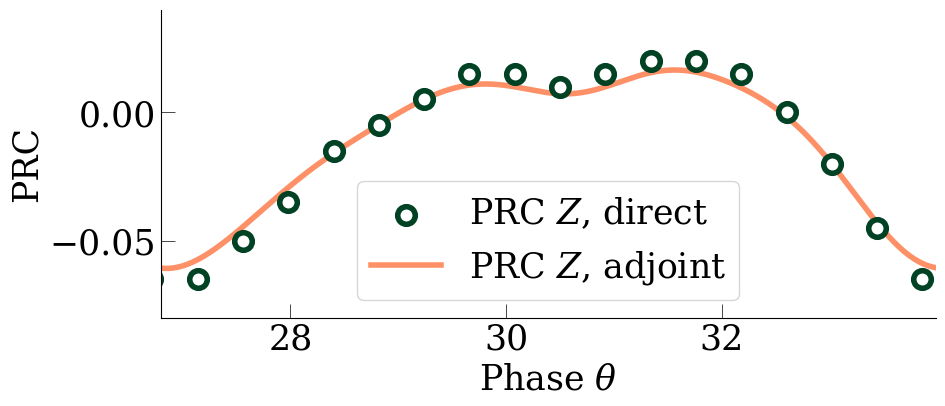

In [4]:
params   = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "PRC", **params)
savefile = os.path.join(output_dir, filename)
data     = np.load(savefile, allow_pickle=True)          
t, synEE, synII, ZE, ZI = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
Z = np.add(ZE, ZI)

params    = get_params_for_filename(param_keys, globals())
filename  = get_filename("lognormal", "Direct_PRC", **params)
savefile  = os.path.join(output_dir, filename)
data      = np.load(savefile, allow_pickle=True)  
impulse_onset, phaseshift = data[:,0], data[:,1]

### don't plot all data
#######################
jump = 6
impulse_onset = impulse_onset[::jump]
phaseshift = phaseshift[::jump] 

t = t - 0.5
Z = Z * 0.02
phase_length = 7.1845
phase_onset  = 26.8

apply_plot_settings()
fig, ax = plt.subplots(figsize=(10, 4))  # Explicitly define figure size

ax.scatter(impulse_onset, phaseshift, label='PRC $Z$, direct', s=160, facecolors='white', edgecolors= '#014225', linewidths = 4, zorder=2)
ax.plot(t, Z, label='PRC $Z$, adjoint', color = '#FD4700', zorder=1, linewidth = 4, alpha = 0.6)
ax.set_xlim(phase_onset, phase_onset+phase_length)
ax.set_ylim(-0.08, 0.04)
ax.set_xlabel(r'Phase $\theta$')
ax.set_ylabel('PRC')
ax.legend()

plt.show()